Grupo 1:
* André Martins
* Artur
* Hugo
* Marcelo
* Pedro Saraiva

# Parametros e Bibliotecas

In [180]:
import torch
import math
from matplotlib import pyplot as plt
from torch.autograd import grad

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

N = 400               # numero total de amostras do dataset
NOISE = 20.           # intensidade do ruido de coleta no dataset
SPLIT_RATIO = 0.5     # porcentagem de dados usados no dataset de treino
BATCH_SIZE = 10       # tamanho do batch usado durante o treinamento
LEARNING_RATE = 0.03  # taxa de aprendizado

# Inicializando os Datasets

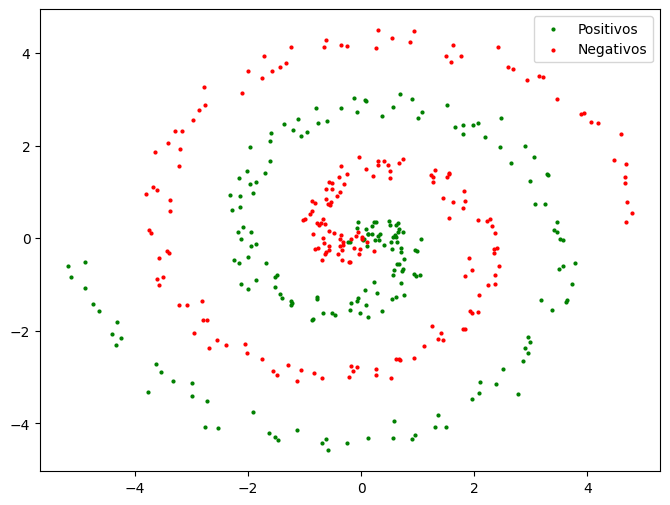

In [204]:
def genSpiral(delta_t, label):
    r = 5*torch.linspace(0., 1., N//2+1)[:N//2]
    t = 0.7*r*math.pi + delta_t
    x0 = r*torch.sin(t)
    x1 = r*torch.cos(t)
    y = label*torch.ones_like(x0)
    x = torch.stack((x0, x1), -1)
    sampled_noise = (NOISE/70.)*(2*torch.rand(N//2, 2) - 1.)
    x += sampled_noise
    return x, y

class SpiralDataset:
    def __init__(self):
        xp, yp = genSpiral(0, 1) # positive samples
        xn, yn = genSpiral(math.pi, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))


df_Spiral = SpiralDataset()


#df.X ->conjuntos de pontos (x,y) de um sistema de coordenadas cartesianas
#df.Y ->rótulos (positivo/negativo) de cada conjunto de pontos





positivos = df_Spiral.X[df_Spiral.Y==1] #conjunto de 200 pontos com rótulo positivo
negativos = df_Spiral.X[df_Spiral.Y==-1] #conjunto de 200 pontos com rótulo negativo
plt.figure(figsize=(8, 6))
plt.scatter(positivos[:,0], positivos[:,1], color = 'green', label='Positivos', s = 4)
plt.scatter(negativos[:,0], negativos[:,1], color = 'red', label='Negativos', s = 4)
plt.legend()
plt.show()



# TODO: plotar dataset gerado

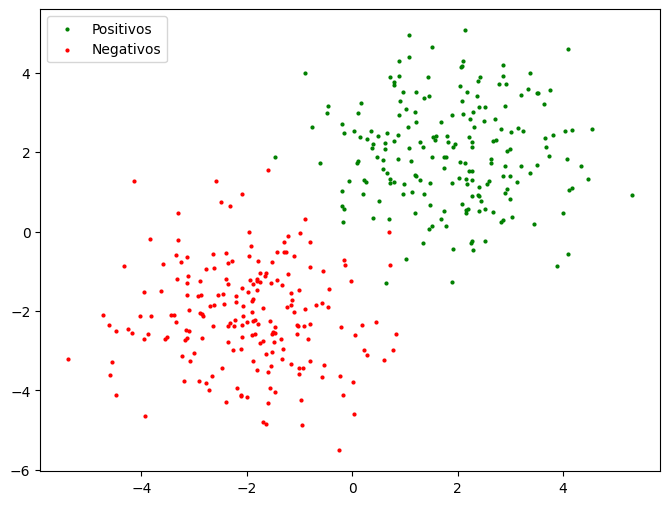

In [205]:
def genGauss(cx0, cx1, label):
    x = 0.7*torch.randn(N//2, 2)
    x = torch.tensor([cx0, cx1]) + x + x*(NOISE/25.)
    y = label*torch.ones(N//2)
    return x, y

class GaussDataset:
    def __init__(self):
        xp, yp = genGauss(2, 2, 1) # positive samples
        xn, yn = genGauss(-2, -2, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))

df_Gauss = GaussDataset()


positives = df_Gauss.X[df_Gauss.Y==1]
negatives = df_Gauss.X[df_Gauss.Y==-1]
plt.figure(figsize=(8, 6))
plt.scatter(positives[:,0], positives[:,1], color = 'green', label='Positivos', s=4)
plt.scatter(negatives[:,0], negatives[:,1], color = 'red', label='Negativos', s=4)
plt.legend()
plt.show()

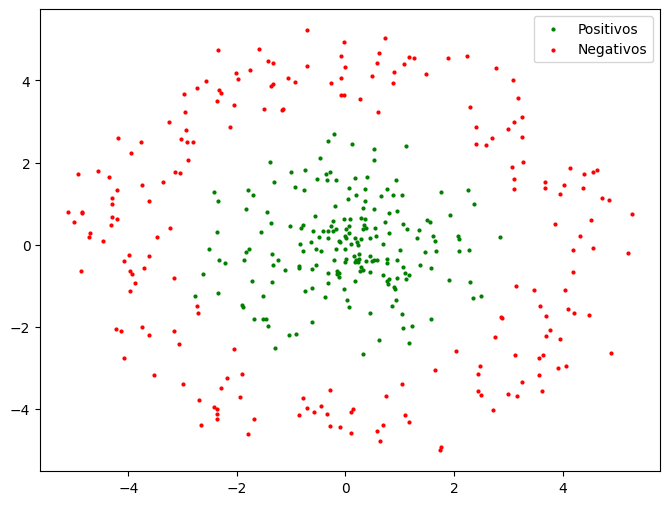

In [206]:
def genCircle(r_min, r_max, label):
    r = (r_max - r_min)*torch.rand(N//2) + r_min
    angle = 2*math.pi*torch.rand(N//2)
    x0 = r*torch.sin(angle)
    x1 = r*torch.cos(angle)
    x = torch.stack((x0, x1), -1)
    sampled_noise = (NOISE/35.)*(2*torch.rand(N//2, 2) - 1.)
    x += sampled_noise
    y = label*torch.ones_like(x0)
    return x, y

class CircleDataset:
    def __init__(self):
        xp, yp = genCircle(0, 2.5, 1) # positive samples
        xn, yn = genCircle(3.5, 5, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))


df_Circle = CircleDataset()

positives = df_Circle.X[df_Circle.Y==1]
negatives = df_Circle.X[df_Circle.Y==-1]
plt.figure(figsize=(8, 6))
plt.scatter(positives[:,0], positives[:,1], color = 'green', label='Positivos', s=4)
plt.scatter(negatives[:,0], negatives[:,1], color = 'red', label='Negativos', s=4)
plt.legend()
plt.show()

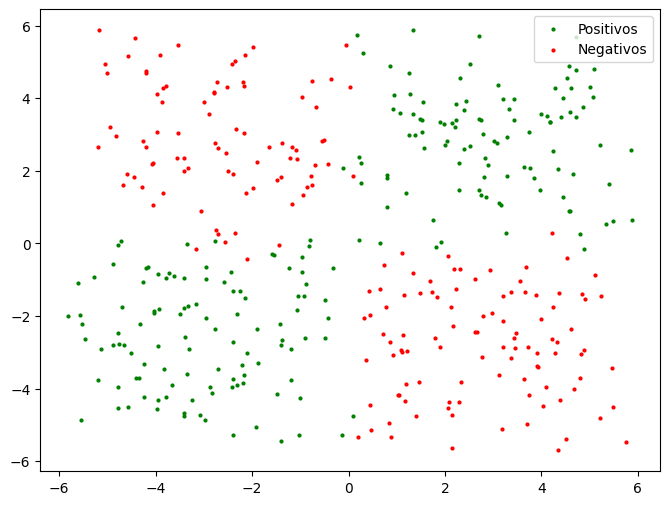

In [207]:
def genXOR():
    x = 10.*torch.rand(N, 2) - 5.
    y = torch.sign(x[:,0]*x[:,1])
    padding = 0.3
    x += torch.sign(x)*padding
    sampled_noise = (NOISE/25.)*(2*torch.rand(N, 2) - 1.)
    x += sampled_noise
    return x, y

class XORDataset:
    def __init__(self):
        self.X, self.Y = genXOR()

df_XOR = XORDataset()

positives = df_XOR.X[df_XOR.Y==1]
negatives = df_XOR.X[df_XOR.Y==-1]
plt.figure(figsize=(8, 6))
plt.scatter(positives[:,0], positives[:,1], color = 'green', label='Positivos', s=4)
plt.scatter(negatives[:,0], negatives[:,1], color = 'red', label='Negativos', s=4)
plt.legend()
plt.show()
# TODO: plotar dataset gerado

# Train Test Split

In [208]:
import torch

def train_test_split(df_x, df_y):

  index = torch.randperm(len(df_x)) #criando uma lista dos indíces do dataset permutados de maneira aleatória
  index_split_train = index[:int(len(df_x)*SPLIT_RATIO)] #pegando os 200 primeiros indíces permutados que serão para o treino. Lembrando que podem ter valores com classificação como 0 e 1
  index_split_test = index[int(len(df_y)*SPLIT_RATIO):] #pegando os últimos 200 indíces permutados que serão para o teste. lembrando que também podem ter valores com classificação como 0 e 1

  X_train = df_x[index_split_train] #atribuindo os indíces permutados das features do dataset de treino
  Y_train = df_y[index_split_train] #atribuindo os indíces permutados dos targets do dataset de treino

  X_test = df_x[index_split_test] #atribuindo os índices permutados das features do dataset de teste
  Y_test = df_y[index_split_test] #atribuindo os índices permutados dos targets do dataset de teste

  return X_train, Y_train, X_test, Y_test


In [209]:
# binarizacao da coluna target
df_Gauss.Y = torch.where(df_Gauss.Y == -1, torch.tensor(0), df_Gauss.Y)   #Estou transofrmando os targets -1 em 0
df_XOR.Y = torch.where(df_XOR.Y == -1, torch.tensor(0), df_XOR.Y)
df_Spiral.Y = torch.where(df_Spiral.Y == -1, torch.tensor(0), df_Spiral.Y)
df_Circle.Y = torch.where(df_Circle.Y == -1, torch.tensor(0), df_Circle.Y)

# **M**ulti**L**ayer **P**erceptron (**MLP**)

Incluindo diversas camadas de ativação

## Classes e Funcoes

In [187]:
def func_ativ(func, x):
    if func == 'sigmoid':
        return 1 / (1 + torch.exp(-x))   #sigmoid

    if func == 'relu':
        return torch.relu(x)    #relu

    if func == 'tanh':
        return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))   #tangente hiperbólica

In [188]:
# neuronios
class Perceptron:
    def __init__(self, qtd_entradas, ativacao='sigmoid'): #por padrao vem a sigmoid
        self.qtd_features = qtd_entradas
        self.ws = torch.rand(qtd_entradas, requires_grad=True)  # inicializar n pesos com, onde n é a quantidade de entradas do neurônio, com valores entre 0 e 1
        self.bias = torch.rand(1, requires_grad=True)   # inicializando um bias (viés)
        self.ativacao = ativacao

    def inference(self, inp):
        return func_ativ(self.ativacao, torch.matmul(self.ws, torch.tensor(inp,dtype=torch.float)) + self.bias)  #aplica a função de ativação escolhida para o somatorio das entradas * seus respectivos pesos, adicionado de um bias



In [189]:
# camadas
class Camada:
        def __init__(self, n_neuronios, n_pesos, ativ='sigmoid'):    #A classe camada cria uma lista, onde armazenamos a quantidade de neurônios existentes naquela camada
            neuronios = []
            for i in range(n_neuronios):
                neuronios.append(Perceptron(n_pesos, ativacao=ativ))

            self.neuronios = neuronios

        def inference(self, inp):   #retorna um tensor(lista) das inferencias de cada neuronio da camada, na posição 0, está a inferência do neurônio 1, e assim por diante.
            return torch.tensor([n.inference(inp) for n in self.neuronios])

In [190]:
class Model:
    def __init__(self, n_features, n_camadas, neuronios_camada=None, ativacao='sigmoid'):

        if neuronios_camada == None:# Se o número de neurônios por camada não for fornecido, ele é definido da maneira abaixo
            neuronios_camada = [2] * (n_camadas - 1) + [1]

        self.neuronios_por_camada = neuronios_camada
        self.n_camadas = n_camadas
        self.camadas_ocultas = n_camadas - 2
        self.ativacao = ativacao

        if n_camadas > 1: # Se houver mais de uma camada, são criadas as instâncias de camadas usando a classe 'Camada',
                          # onde cada camada recebe o número apropriado de neurônios e as conexões entre eles.
          self.camadas = (
                  [Camada(self.neuronios_por_camada[0], n_features, ativ=self.ativacao)] +
                  [Camada(self.neuronios_por_camada[i], self.neuronios_por_camada[i -1],ativ=self.ativacao) for i in range(1, self.camadas_ocultas +1)] +
                  [Camada(self.neuronios_por_camada[-1], self.neuronios_por_camada[-2],ativ=self.ativacao)]  # as camadas em diante lidam com os outputs da camada anterior, até a última camada
          )
        else: # Caso contrário, se houver apenas uma camada, é criada uma única camada.
          self.camadas = [Camada(self.neuronios_por_camada[0], n_features,ativ=self.ativacao)]



    def zerograd(self):   #Função para zerar os gradientes de todos os pesos e bias de todos os neurônios envolvidos no modelo, útil para o backpropagation
        for l in self.camadas: #Itera sobre todas as camadas do modelo.
            for n in l.neuronios: #Itera sobre todos os neurônios da camada.
                if n.ws.grad is not None:
                    n.ws.grad.zero_() #Se o gradiente dos pesos do neurônio não for nulo, zera o gradiente.
                if n.bias.grad is not None:
                    n.bias.grad.zero_() #Se o gradiente do bias do neurônio não for nulo, zera o gradiente.

    def inference(self, inp): # Função para realizar a inferência (forward pass) do modelo.
      inp = torch.tensor(inp, dtype=torch.float).T # Converte a entrada para um tensor do PyTorch com tipo de dado float e transpõe a matriz.
      prop_value = inp # Inicializa prop_value com a entrada transposta.

      for l in self.camadas: #Itera sobre todas as camadas do modelo.
        prop_value = torch.stack( [ n.inference(prop_value) for n in l.neuronios]) #Para cada camada, realiza a inferência para cada neurônio na camada e empilha os resultados em um tensor.

      return prop_value

    def evaluate(self, x, target, threshold=0.5):  #Função para avaliar a acurácia, onde temos um limiar de 0.5. Ou seja, todos os valores acima disso virarão positivo (1), e abaixo negativo (0)
      erro = 0
      acerto = 0

      for i, xi in enumerate(x): #Itera sobre os exemplos de entrada e seus respectivos rótulos.
          y_hat = self.inference(xi)  #Realiza a inferência do modelo para o exemplo de entrada xi.

          y_hat_class = 1 if y_hat >= threshold else 0 # Converte a saída contínua para uma classe binária usando o limiar fornecido.

          if y_hat_class != target[i]:
              erro += 1
          else:
              acerto += 1

      accuracy = acerto / (acerto + erro) if (acerto + erro) > 0 else 0 #Calcula a acurácia como a razão de acertos sobre o total de exemplos, evitando divisão por zero.

      print(f'Erros: {erro}')
      print(f'Acertos: {acerto}')
      print(f'Acurácia do mlp: {accuracy:.4f}')



Possibilitando a esolha de diferentes métodos para o cáclulo de loss

In [191]:
def calcula_loss(y, y_hat, metodo='abs'):  #Assim como a escolha da função de ativação, também é possível escolher a função de erro
  if metodo == 'binary_cross_entropy':
    return - (y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))

  if metodo == 'mse':
    return (y-y_hat)**2

  if metodo == 'abs':
    return abs(y-y_hat)

In [192]:
def train_loop(model, x, target, epocas, learning_rate, batch_size=5, metodo_loss='abs', ativacao='sigmoid'):
    X_train, Y_train, X_test, Y_test = train_test_split(x, target) #a divisão entre treino e teste será feita na propria função, para que não fiquem muitos parâmetros

    x = X_train
    target = Y_train
    model.ativacao = ativacao


    # Listas para armazenar os valores de perda
    test_losses = []
    train_losses = []

    for epc in range(epocas):  #Para cada época iremos percorrer todos os dados, calcular a inferência,e a partir do erro (por lotes (batch_size)) com o backpropagation atualizar os pesos e bias .
        losses = []

        with torch.no_grad():
            test_batch_y_hat = [model.inference(xi) for xi in X_test]
            test_batch_loss = [calcula_loss(ti, yi, metodo_loss) for ti, yi in zip(Y_test, test_batch_y_hat)]
            test_loss_media = (sum(test_batch_loss) / len(test_batch_loss)).item()
            test_losses.append(test_loss_media)


        for batch_start in range(0, len(x), batch_size):
            batch_end = min(batch_start + batch_size, len(x))
            batch_x = x[batch_start:batch_end]
            batch_target = target[batch_start:batch_end]

            model.zerograd()
            batch_y_hat = [model.inference(xi) for xi in batch_x]
            batch_loss = [calcula_loss(ti, yi, metodo_loss) for ti, yi in zip(batch_target, batch_y_hat)]


            losses.extend([loss.item() for loss in batch_loss])

            batch_loss = sum(batch_loss)
            batch_loss.backward()

            with torch.no_grad():   #Atualização dos pesos, com base no gradiente calculado a partir da perda
                for l in model.camadas:
                    for n in l.neuronios:
                        if n.ws.grad is not None:
                            n.ws -= n.ws.grad * learning_rate
                        if n.bias.grad is not None:
                            n.bias -= n.bias.grad * learning_rate

        loss_media = sum(losses) / len(losses)
        train_losses.append(loss_media)

        print(f'Média do loss para a época {epc}: {loss_media}')

    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Perdas de Treinamento e Teste por Época')

    # Exibe o gráfico
    plt.show()
    print()
    print()

    return X_test, Y_test

## MLP para Gaussiano

<ipython-input-190-e32ad4dc9b7b>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp, dtype=torch.float).T # Converte a entrada para um tensor do PyTorch com tipo de dado float e transpõe a matriz.
<ipython-input-188-d8d10575b191>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func_ativ(self.ativacao, torch.matmul(self.ws, torch.tensor(inp,dtype=torch.float)) + self.bias)  #aplica a função de ativação escolhida para o somatorio das entradas * seus respectivos pesos, adicionado de um bias


Média do loss para a época 0: 0.41181078463792803
Média do loss para a época 1: 0.3770518396794796
Média do loss para a época 2: 0.34307335555553437
Média do loss para a época 3: 0.3119014701247215
Média do loss para a época 4: 0.28440287195146086
Média do loss para a época 5: 0.26057912431657315
Média do loss para a época 6: 0.24007236145436764
Média do loss para a época 7: 0.2224331522732973
Média do loss para a época 8: 0.2072235180810094
Média do loss para a época 9: 0.19405303463339807
Média do loss para a época 10: 0.18258839804679156
Média do loss para a época 11: 0.1725514220446348
Média do loss para a época 12: 0.16371274253353477
Média do loss para a época 13: 0.1558841934800148
Média do loss para a época 14: 0.14891147995367646
Média do loss para a época 15: 0.14266793807968497
Média do loss para a época 16: 0.1370491631142795
Média do loss para a época 17: 0.13196876853704453
Média do loss para a época 18: 0.12735481567680837
Média do loss para a época 19: 0.123147156806662

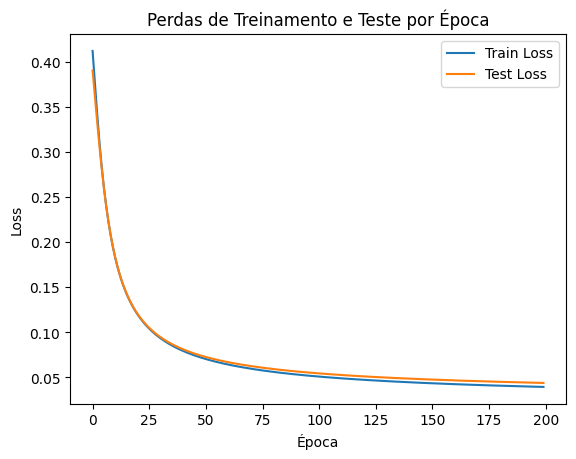

In [193]:
Gaussiano = Model(2, 2)
X_test, Y_test = train_loop(Gaussiano,df_Gauss.X, df_Gauss.Y, 200, 0.03,ativacao='relu', metodo_loss='abs')

In [194]:
Gaussiano.evaluate(X_test,Y_test)

Erros: 4
Acertos: 196
Acurácia do mlp: 0.9800


<ipython-input-190-e32ad4dc9b7b>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp, dtype=torch.float).T # Converte a entrada para um tensor do PyTorch com tipo de dado float e transpõe a matriz.
<ipython-input-188-d8d10575b191>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func_ativ(self.ativacao, torch.matmul(self.ws, torch.tensor(inp,dtype=torch.float)) + self.bias)  #aplica a função de ativação escolhida para o somatorio das entradas * seus respectivos pesos, adicionado de um bias


## MLP para XOR

<ipython-input-168-82662289de31>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp, dtype=torch.float).T # Converte a entrada para um tensor do PyTorch com tipo de dado float e transpõe a matriz.
<ipython-input-161-d8d10575b191>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func_ativ(self.ativacao, torch.matmul(self.ws, torch.tensor(inp,dtype=torch.float)) + self.bias)  #aplica a função de ativação escolhida para o somatorio das entradas * seus respectivos pesos, adicionado de um bias


Média do loss para a época 0: 0.5065619137883186
Média do loss para a época 1: 0.5029171538352967
Média do loss para a época 2: 0.4996033999323845
Média do loss para a época 3: 0.4965726518630981
Média do loss para a época 4: 0.49375555276870725
Média do loss para a época 5: 0.4910646423697472
Média do loss para a época 6: 0.48840778291225434
Média do loss para a época 7: 0.4856998720765114
Média do loss para a época 8: 0.4828698271512985
Média do loss para a época 9: 0.47986386746168136
Média do loss para a época 10: 0.4766461208462715
Média do loss para a época 11: 0.4731977275013924
Média do loss para a época 12: 0.46951522514224053
Média do loss para a época 13: 0.4656084023416042
Média do loss para a época 14: 0.4614980565011501
Média do loss para a época 15: 0.4572134791314602
Média do loss para a época 16: 0.4527903945744038
Média do loss para a época 17: 0.4482689893245697
Média do loss para a época 18: 0.4436916898190975
Média do loss para a época 19: 0.43910064309835434
Média

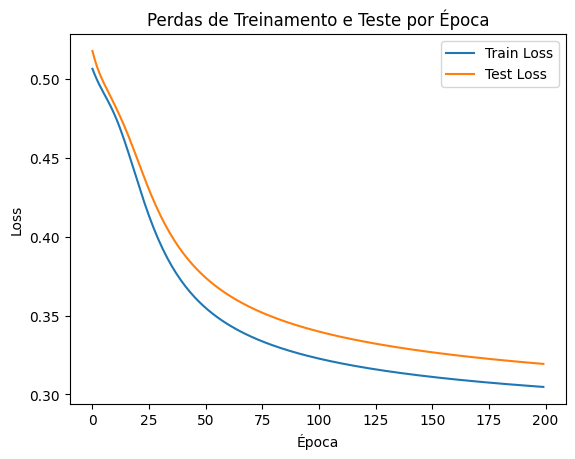

In [175]:
XOR = Model(2,2, [2, 1])   #aqui escolhemos propositalmente a primeira camada com 2 neuronios, e a ultima com 1. Isso pois, caso a primeira camada represente os problemas or e nand e a ultima o and, temos o xor
X_test, Y_test = train_loop(XOR, df_XOR.X, df_XOR.Y, 200, 0.12, ativacao='sigmoid', metodo_loss='abs',batch_size=1)

In [176]:
xor.evaluate(X_test, Y_test)

Erros: 61
Acertos: 139
Acurácia do mlp: 0.6950


<ipython-input-40-9ed88b9ff567>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp, dtype=torch.float).T
<ipython-input-38-d8d10575b191>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func_ativ(self.ativacao, torch.matmul(self.ws, torch.tensor(inp,dtype=torch.float)) + self.bias)  #aplica a função de ativação escolhida para o somatorio das entradas * seus respectivos pesos, adicionado de um bias


## MLP para Circle

<ipython-input-190-e32ad4dc9b7b>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp, dtype=torch.float).T # Converte a entrada para um tensor do PyTorch com tipo de dado float e transpõe a matriz.
<ipython-input-188-d8d10575b191>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func_ativ(self.ativacao, torch.matmul(self.ws, torch.tensor(inp,dtype=torch.float)) + self.bias)  #aplica a função de ativação escolhida para o somatorio das entradas * seus respectivos pesos, adicionado de um bias


Média do loss para a época 0: 0.6999998120963573
Média do loss para a época 1: 0.682548062801361
Média do loss para a época 2: 0.6708004774153232
Média do loss para a época 3: 0.6595354835689068
Média do loss para a época 4: 0.6487205436825753
Média do loss para a época 5: 0.6383358559012413
Média do loss para a época 6: 0.6283622440695763
Média do loss para a época 7: 0.6187811836600303
Média do loss para a época 8: 0.609574839770794
Média do loss para a época 9: 0.6007259929180145
Média do loss para a época 10: 0.5922181305289268
Média do loss para a época 11: 0.5840354140102864
Média do loss para a época 12: 0.5761627748608589
Média do loss para a época 13: 0.5685856652259826
Média do loss para a época 14: 0.5612902690470218
Média do loss para a época 15: 0.5542633980512619
Média do loss para a época 16: 0.5474925099313259
Média do loss para a época 17: 0.5409656532108784
Média do loss para a época 18: 0.5346714641153812
Média do loss para a época 19: 0.5285991267114878
Média do los

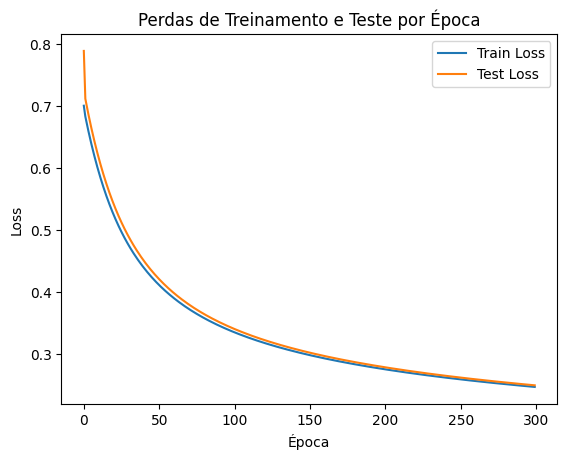

In [216]:
Circle = Model(2,2)
X_test, Y_test = train_loop(Circle, torch.cat([df_Circle.X**2], dim=1), df_Circle.Y, 300, 0.04,  metodo_loss='binary_cross_entropy', ativacao='relu') #Aqui não estamos passando  a feature1 e feature2, mas estamos também ambas ao quadrado

In [217]:
Circle.evaluate(torch.cat([X_test**2], dim=1), Y_test) #usar relu

Erros: 33
Acertos: 167
Acurácia do mlp: 0.8350


<ipython-input-190-e32ad4dc9b7b>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp, dtype=torch.float).T # Converte a entrada para um tensor do PyTorch com tipo de dado float e transpõe a matriz.
<ipython-input-188-d8d10575b191>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func_ativ(self.ativacao, torch.matmul(self.ws, torch.tensor(inp,dtype=torch.float)) + self.bias)  #aplica a função de ativação escolhida para o somatorio das entradas * seus respectivos pesos, adicionado de um bias


## MLP para Spiral

<ipython-input-190-e32ad4dc9b7b>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp, dtype=torch.float).T # Converte a entrada para um tensor do PyTorch com tipo de dado float e transpõe a matriz.
<ipython-input-188-d8d10575b191>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func_ativ(self.ativacao, torch.matmul(self.ws, torch.tensor(inp,dtype=torch.float)) + self.bias)  #aplica a função de ativação escolhida para o somatorio das entradas * seus respectivos pesos, adicionado de um bias


Média do loss para a época 0: 0.7257791812717914
Média do loss para a época 1: 0.7034314009547233
Média do loss para a época 2: 0.7029642543196678
Média do loss para a época 3: 0.7025752037763595
Média do loss para a época 4: 0.7022291195392608
Média do loss para a época 5: 0.7019207717478275
Média do loss para a época 6: 0.7016457016766071
Média do loss para a época 7: 0.7013999801874161
Média do loss para a época 8: 0.7011801512539386
Média do loss para a época 9: 0.7009831875562668
Média do loss para a época 10: 0.7008064076304436
Média do loss para a época 11: 0.700647469162941
Média do loss para a época 12: 0.7005042618513108
Média do loss para a época 13: 0.7003749845921994
Média do loss para a época 14: 0.700258020311594
Média do loss para a época 15: 0.7001519547402859
Média do loss para a época 16: 0.7000555381178856
Média do loss para a época 17: 0.6999676716327667
Média do loss para a época 18: 0.699887385815382
Média do loss para a época 19: 0.6998138166964054
Média do loss

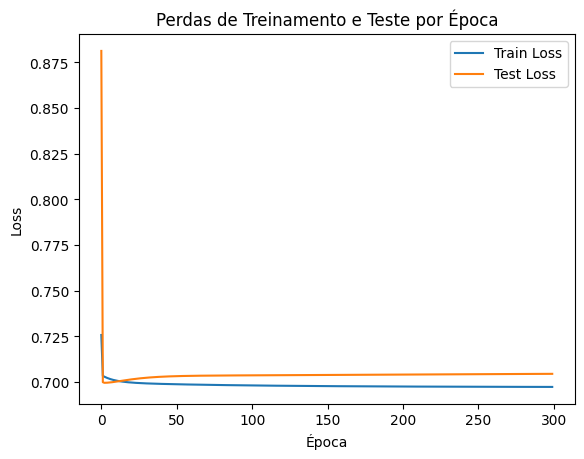

In [222]:
Spiral = Model(4,2, [2, 1])
X_test, Y_test = train_loop(Spiral, torch.cat([df_Spiral.X,df_Spiral.X**2], dim=1), df_Spiral.Y, 300, 0.04, ativacao='sigmoid', metodo_loss='binary_cross_entropy')

In [223]:
Spiral.evaluate(torch.cat([df_Spiral.X,df_Spiral.X**2], dim=1), df_Spiral.Y)

Erros: 200
Acertos: 200
Acurácia do mlp: 0.5000


<ipython-input-190-e32ad4dc9b7b>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp, dtype=torch.float).T # Converte a entrada para um tensor do PyTorch com tipo de dado float e transpõe a matriz.
<ipython-input-188-d8d10575b191>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func_ativ(self.ativacao, torch.matmul(self.ws, torch.tensor(inp,dtype=torch.float)) + self.bias)  #aplica a função de ativação escolhida para o somatorio das entradas * seus respectivos pesos, adicionado de um bias


# **k**-**N**earest **N**eighbors (**k-NN**)


## Spiral

O melhor valor de k é 1 com uma acurácia de 0.9899999999999985


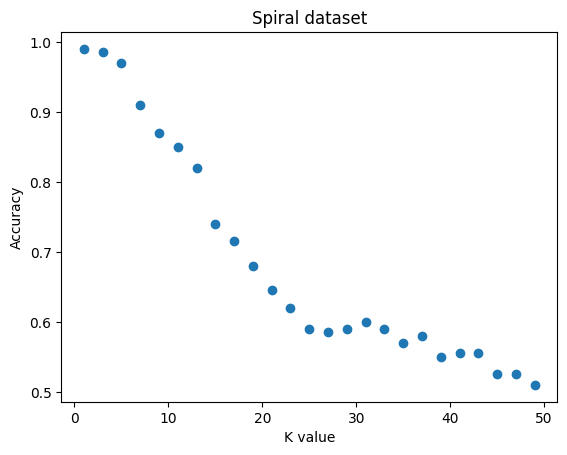

In [130]:
x_train, y_train, x_test, y_test = train_test_split(df_Spiral.X, df_Spiral.Y)

spiral_accuracies = {}

for i in range(1,50):
  if i%2 !=0:
    spiral_accuracies[i] = 0

for j in range(0,100):
  for i in range(1, 50):
    if i%2 != 0: #pegando valores ímpares de K para não haver empate.
      knn_classifier = KNeighborsClassifier(n_neighbors=i)
      knn_classifier.fit(x_train, y_train)
      y_pred = knn_classifier.predict(x_test)
      accuracy = accuracy_score(y_test, y_pred)
      spiral_accuracies[i] += accuracy


for chave, valor in spiral_accuracies.items():
  spiral_accuracies[chave] = valor / 100

max_key = max(spiral_accuracies, key=spiral_accuracies.get)
print(f"O melhor valor de k é {max_key} com uma acurácia de {spiral_accuracies[max_key]}")
acc = spiral_accuracies[max_key]
plt.title("Spiral dataset")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.scatter(spiral_accuracies.keys(), spiral_accuracies.values())
plt.show()


## Gaussiano

O melhor valor de k é 7 com uma acurácia de 0.9950000000000009


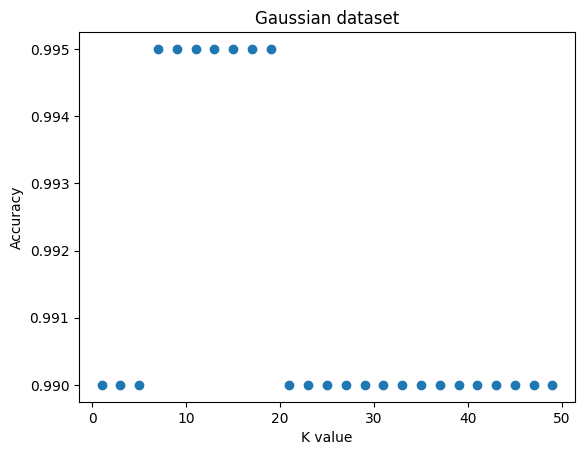

In [137]:
x_train, y_train, x_test, y_test = train_test_split(df_Gauss.X, df_Gauss.Y)

gauss_accuracies = {}

for i in range(1,50):
  if i%2 !=0:
    gauss_accuracies[i] = 0

for j in range(0,100):
  for i in range(1, 50):
    if i%2 != 0: #pegando valores ímpares de K para não haver empate.
      knn_classifier = KNeighborsClassifier(n_neighbors=i)
      knn_classifier.fit(x_train, y_train)
      y_pred = knn_classifier.predict(x_test)
      accuracy = accuracy_score(y_test, y_pred)
      gauss_accuracies[i] += accuracy

for chave, valor in gauss_accuracies.items():
  gauss_accuracies[chave] = valor / 100

max_key = max(gauss_accuracies, key=gauss_accuracies.get)
print(f"O melhor valor de k é {max_key} com uma acurácia de {gauss_accuracies[max_key]}")
acc_gauss = gauss_accuracies[max_key]
plt.title("Gaussian dataset")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.scatter(gauss_accuracies.keys(), gauss_accuracies.values())
plt.show()

## Circle

O melhor valor de k é 3 com uma acurácia de 1.0


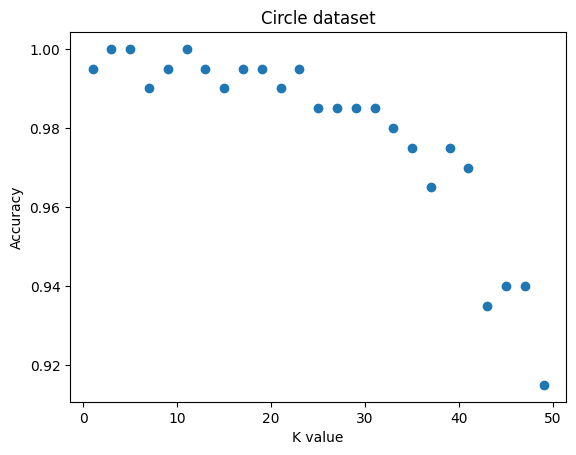

In [128]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

x_train, y_train, x_test, y_test = train_test_split(df_Circle.X, df_Circle.Y)

circle_accuracies = {}

for i in range(1,50):
  if i%2 !=0:
    circle_accuracies[i] = 0


for j in range(0,100):
  for i in range(1, 50):
    if i%2 != 0: #pegando valores ímpares de K para não haver empate.
      knn_classifier = KNeighborsClassifier(n_neighbors=i)
      knn_classifier.fit(x_train, y_train)
      y_pred = knn_classifier.predict(x_test)
      accuracy = accuracy_score(y_test, y_pred)
      circle_accuracies[i] += accuracy

for chave, valor in circle_accuracies.items():
  circle_accuracies[chave] = valor / 100

max_key_circle = max(circle_accuracies, key=circle_accuracies.get)
print(f"O melhor valor de k é {max_key_circle} com uma acurácia de {circle_accuracies[max_key_circle]}")
acc_circle = circle_accuracies[max_key_circle]
plt.title("Circle dataset")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.scatter(circle_accuracies.keys(), circle_accuracies.values())
plt.show()

## XOR

O melhor valor de k é 31 com uma acurácia de 0.9749999999999988


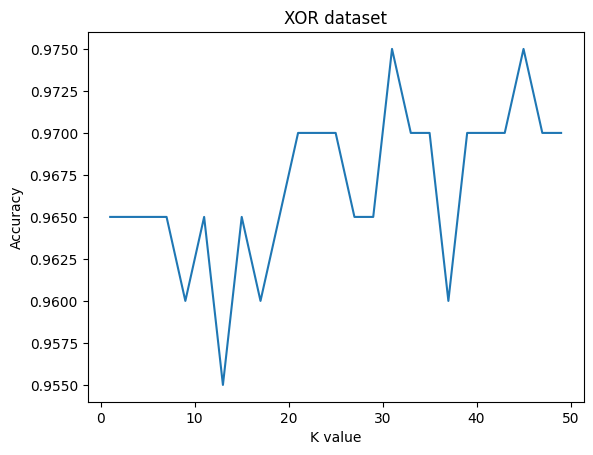

In [136]:
x_train, y_train, x_test, y_test = train_test_split(df_XOR.X, df_XOR.Y)

XOR_accuracies = {}

for i in range(1,50):
  if i%2 !=0:
    XOR_accuracies[i] = 0

for j in range(0,100):
  for i in range(1, 50):
    if i%2 != 0: #pegando valores ímpares de K para não haver empate.
      knn_classifier = KNeighborsClassifier(n_neighbors=i)
      knn_classifier.fit(x_train, y_train)
      y_pred = knn_classifier.predict(x_test)
      accuracy = accuracy_score(y_test, y_pred)
      XOR_accuracies[i] += accuracy

for chave, valor in XOR_accuracies.items():
  XOR_accuracies[chave] = valor / 100

max_key = max(XOR_accuracies, key=XOR_accuracies.get)
print(f"O melhor valor de k é {max_key} com uma acurácia de {XOR_accuracies[max_key]}")
acc_xor = XOR_accuracies[max_key]
plt.title("XOR dataset")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.plot(XOR_accuracies.keys(), XOR_accuracies.values())
plt.show()

# Avaliação

Compare as melhores performances obtidas com as MLPs e as melhores obtidas com o k-NN. Quais as vantagens e desvantagens de cada algoritmo para os datasets explorados? Se tivesse que escolher um dos dois algoritmos, qual seu time escolheria?

**Resposta:**

 Primeiro ponto que toda a equipe concorda, a complexida na implementação dos algoritmos, o KNN foi relativamente facil de estudar apenas utilizando a biblioteca do Sckit-learn conseguimos resolver o problema e obter uma performance muito boa utilizando o KNN. Inclusive não precisariamos da biblioteca do Sckit-learn pois a distancia euclidiana é de facil implementação até mesmo manualmente.

  Já no lado da MLP todos da equipe concordam que é de extrema dificuldade a implementação dessa rede (ainda mais de forma mais manual), todos nós ficamos boas horas e levamos alguns dias para conseguir montar a rede da forma correta e sem bugs (aparentemente).

---
Vale lembrar tambem que estamos com os seguintes parametros iniciais:

N = 400               numero total de amostras do dataset

NOISE = 20.            intensidade do ruido de coleta no dataset

SPLIT_RATIO = 0.5      porcentagem de dados usados no dataset de treino

BATCH_SIZE = 10        tamanho do batch usado durante o treinamento

LEARNING_RATE = 0.03   taxa de aprendizado

---

*   Obtivemos as seguintes acurácias:

<br>


| Dataset | MLP Acurácia | k-NN Acurácia |
|:-------:|:------------:|:-------------:|
| Spiral  | 50%          | 98,9%         |
| Gauss   | 99,5%          | 98,9%         |
| Circle  | 83,5%          | 100%          |
| XOR     | 66,3%          | 97,49%         |

<br>

É importante lembrar que esses resultados foram obtidos utilizando parâmetros diferentes para cada dataset em busca de melhores resultados.

<br>

E para o nosso **k**-**N**earest **N**eighbors (**k-NN**) achamos o melhor valor para K sendo:
<br>

| Dataset | Melhor valor de K |
|:-------:|:-----------------:|
| Spiral  |         1         |
| Gauss   |         7         |
| Circle  |        3         |
| XOR     |         31        |

<br>

Após analisar os resultados obtidos e os insights que podemos tirar são:


**MLP VANTAGENS:**


*   Flexibilidade de Arquitetura: Possibilidade de ajustar a arquitetura (número de camadas, neurônios por camada) conforme necessário.

*   Para alta dimensionalidade dos dados, MLPs tendem a se comportar melhor e obter bons resultados.


**MLP DESVANTAGENS:**

*   Necessidade de Treinamento: Requer um processo de treinamento mais longo e intensivo em recursos.


*   Sensibilidade a Hiperparâmetros: A performance é sensível a escolha de hiperparâmetros como taxa de aprendizado (learningrate), número de camadas, função de ativação.


*   Sem bibliotecas de machine leraning sua implementação se torna um dasafio.

*   Dificuldade em parametrização.

*   Requer mais recursos computacionais.

---
**KNN VANTAGENS:**
*   Simplicidade de Implementação: Fácil de implementar e entender.
*   Facilidade dos parametros: Basicamente o mais relevante é o K e não precisa de muitos ajustes.
*   Boa performance: Para os Dataset envolvidos nesse desafio o algoritmo se saiu bem.

**KNN DESVANTAGENS:**
*   Algoritmo baseado na distancia: Só existe essa possibilidade para separar os dados, apenas as distancias entre eles, o que faz com que se fixe a um unico metodo e não abrindo brecha para outras abordagens.

*   Essa algoritmo é sensível a outliers, ou seja, quanto mais dados de ruído, menor são seus scores.


